In [63]:
import torch
import torch.nn as nn
from data_sample import generate_example_data as data
from matplotlib import pyplot as plt
import GP_CommonCalculation as GP
from kernel import ARDKernel
import torch.optim as optim
print(torch.__version__)
# I use torch (1.11.0) for this work. lower version may not work.

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-3
EPS = 1e-10
PI = 3.1415

2.2.1


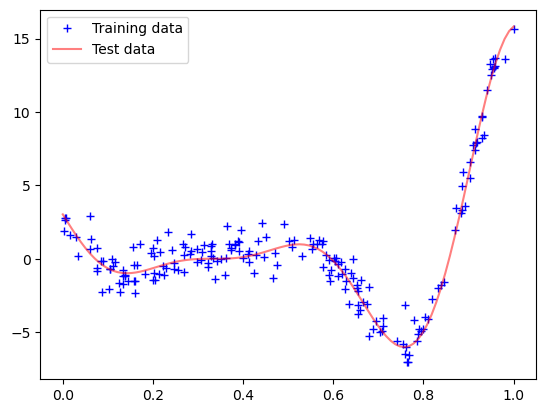

In [64]:
# generate example data
xtr, ytr,xte,yte = data.generate(200,100,seed=42)
data.plot(xtr, ytr,xte,yte)

In [65]:
# Data Normalization
data_normalizer=GP.XYdata_normalization(xtr.clone(), ytr.clone())
xtr, ytr = data_normalizer.normalize(xtr, ytr)

In [66]:
kernel= ARDKernel(1)

In [67]:
log_beta = nn.Parameter(torch.ones(1) * 0)
# initialize inducing point as model parameter
xm=nn.Parameter(torch.rand(20, 1))

In [68]:
def negative_log_likelihood(xtr, ytr, xm,kernel,log_beta):
    n=xtr.size(0)
    K_mm = kernel(xm,xm) + JITTER * torch.eye(xm.size(0))
    K_mn = kernel(xm, xtr)
    K_nn = kernel(xtr, xtr)
    L = torch.linalg.cholesky(K_mm)
    A, _= torch.triangular_solve(K_mn, L, upper=False)
    A=A*torch.sqrt(log_beta.exp())
    AAT = A @ A.t()
    B = torch.eye(xm.size(0))+AAT
    LB=torch.linalg.cholesky(B)
    c,_=torch.triangular_solve(A@ytr,LB,upper=False)
    c=c*torch.sqrt(log_beta.exp())
    nlb=n/2* torch.log(2*torch.tensor(PI))+torch.sum(torch.log(torch.diagonal(LB)))+n / 2 * torch.log(1/log_beta.exp())+\
    log_beta.exp()/2 * torch.sum(ytr * ytr)-0.5 * torch.sum(c.squeeze() * c.squeeze())+\
    log_beta.exp()/2 * torch.sum(torch.diagonal(K_nn))-0.5 * torch.trace(AAT)
    return nlb

In [69]:
def train_adam(xtr, ytr, kernel, xm,log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta,xm]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, xm,kernel, log_beta)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
        if i % 10 == 0:
            print('iter', i, 'nll:{:.5f}'.format(loss.item()))


In [70]:
def OPT(xm,xtr,ytr,kernel, log_beta):

    K_mm = kernel(xm,xm) + JITTER* torch.eye(xm.size(0))
    L = torch.linalg.cholesky(K_mm)
    L_inv = torch.linalg.inv(L)
    K_mm_inv = L_inv.t() @ L_inv
    K_mn = kernel(xm, xtr)
    K_nm=K_mn.t()
    sigma=torch.inverse(K_mm+log_beta.exp()*K_mn@K_nm)

    mean_m=log_beta.exp() * (K_mm @ sigma @ K_mn)@ytr
    A_m=K_mm@sigma@K_mm

    return mean_m, A_m,K_mm_inv   #we need to use K_mm inverse for prediction

In [71]:
def forward(xte,kernel,xm,mean_m,A_m,K_mm_inv):
    xte=data_normalizer.normalize(xte)
    K_tt=kernel(xte,xte)
    K_tm=kernel(xte,xm)
    K_mt= K_tm.t()
    ypred=(K_tm@K_mm_inv)@mean_m
    yvar=K_tt-K_tm@K_mm_inv@K_mt+K_tm@K_mm_inv@A_m@K_mm_inv@K_mt
    yvar = yvar.diag().view(-1,1)
    ypred,yvar=data_normalizer.denormalize_result(ypred,yvar)
    return ypred,yvar

In [72]:
%%time
train_adam(xtr, ytr,kernel,xm, log_beta,200, 0.01)
with torch.no_grad():
    mean_m,A_m,K_mm_inv=OPT(xm,xtr,ytr,kernel, log_beta)

iter 0 nll:255.06830
iter 10 nll:239.95142
iter 20 nll:228.21977
iter 30 nll:211.44992
iter 40 nll:200.07797
iter 50 nll:187.72928
iter 60 nll:174.69859
iter 70 nll:162.32832
iter 80 nll:150.47018
iter 90 nll:138.69002
iter 100 nll:126.39531
iter 110 nll:113.32712
iter 120 nll:100.93994
iter 130 nll:89.39462
iter 140 nll:79.13019
iter 150 nll:69.91418
iter 160 nll:61.52637
iter 170 nll:53.83893
iter 180 nll:46.78650
iter 190 nll:40.33704
CPU times: total: 4.83 s
Wall time: 610 ms


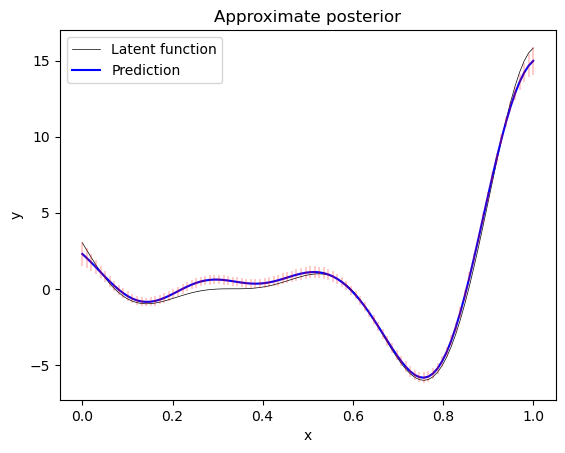

In [73]:
ypred, yvar = forward(xte,kernel,xm,mean_m,A_m,K_mm_inv)
plt.plot(xte.numpy(), yte.numpy(), label='Latent function', c='k', lw=0.5)
plt.plot(xte.numpy(), ypred.detach(), label='Prediction', c='b')
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')

plt.legend();